***
    
# K Nearest Neighbors

Author: Olatomiwa Bifarin. <br>
PhD Candidate Biochemistry and Molecular Biology <br>
@ The University of Georgia

_This is a draft copy, a work in progress_

## Notebook Content

1.  [Description](#1) <br>
2.  [A Simpified Example](#2) <br>
    2.1 [Naive k-NN](#2.1) <br>
    2.2 [A weighted k-NN](#2.2) <br>
3.  [Scikit learn Implementation/Decision Boundaries](#3) <br>

In [11]:
import pandas as pd
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import cm
#For Seaborn plots
import seaborn as sns; sns.set(style='white')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# for datasets
import sklearn.datasets as skds

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

## 1. Description
<a id="1"></a>

k-Nearest Neighbors (kNN) is one of the simplest and intuitive machine learning algorithm out there. It simply _argues_ that a new sample should be classified based on the identity of the _k_ (to be defined) nearest neighbors. In order words, `neighbors should have the same identity`. Note that this is a kind of inductive bias, that is, this is how it generalizes. Another inductive bias in a naive k-NN classifier is the following: `all features are 'created' equally.` Note that there are other types of k-NN that handle the later bias for example, weighted k-NN. 

Once you get the idea behind k-NN, then it is not hard to figure out that the algorithm isn't learning anything _per se_. All it's doing here is storing training examples, and then classifying test data based on the proximity heuristics defined.

Two hyperparameters are important for tuning a naive k-NN classifier. 1) the value of _k_, 2) the distance measure. 

### - Popular Distance Measure

-  L2 distance (Euclidean distance)

$$
d(x,y) = \sqrt{\sum_{i=1}^{n} (x-y)^2}
$$

-  L1 distance 

$$
d(x,y) = \sum_{i=1}^{n} |x - y|
$$

## 2. A Simplified Example
<a id="2"></a>

Assume that we have 6 samples ($𝑥_{i}$, 𝑖 = 1, ... ,6) from two classes (A and B). We aim to classify a test sample $𝑥_{t}$ by using the k-NN classification method. The cosine similarities between $𝑥_{t}$ and $𝑥_{i}$ are provided in the table below.

| Sample| cos($x_i$ $x_d$) | Class Label|
| --- | --- | --- |
| 1| 1.00  | A|
| 2| 0.95  | B|
| 3| 0.94  | B|
| 4| 0.45  | A|
| 5| 0.40 | A|
| 6| 0.39  | B|

### 2.1 Naive k-NN
<a id="2.1"></a>

Let us assume that we use the cosine as a distance metric, i.e., the higher the cosine, the closer are two samples.
For the test sample $𝑥_{t}$, after selecting k nearest neighbors $𝑥_{n1}$, ... , $𝑥_{nk}$ from the dataset, two scoring functions can be used to predict the class label.

Scoring by simple majority vote:

$$ \text{Score}(A,x_{t}) = \sum_{j=1} I_A(x_{nj})$$

$$ I_A(x_{nj}) = 
\begin{cases}
0 & \text{class label} \neq A \\
1 & \text{class label} = A
\end{cases}$$

$$ \text{Score}(B,x_{t}) = \sum_{j=1} I_B(x_{nj})$$

$$ I_B(x_{nj}) = 
\begin{cases}
0 & \text{class label} \neq B \\
1 & \text{class label} = B
\end{cases}$$



In [12]:
# dataframe for the data.
knn = {'Sample': [1, 2, 3, 4, 5, 6], 
     'cos(xd, xi)': [1, 0.95, 0.94, 0.45, 0.4, 0.39], 
     'Class Label': ['A', 'B', 'B', 'A', 'A', 'B']}
df_knn = pd.DataFrame(data=knn)

In [13]:
# k-NN function
def naive_knn(k, distance):
    neigbors = [] # List to store neigbors
    aa = list(distance) # list of the distance between x_t and x_i
    # arrange list in descending order
    aa.sort(reverse=True) # recall that the higher the cosine, the closer are two samples. 
    aa = aa[:k] # Select the top k i.e. the k-neigbors's distances
    for i in aa: # loop through the content of aa
        # select the class membership corresponding to the k-neigbors's distances
        b = list(df_knn.loc[df_knn['cos(xd, xi)'] == i, 'Class Label']) 
        neigbors.append(b) # append class membership to list
    list(neigbors) # remove superflous information from list
    ax = [val for sublist in neigbors for val in sublist] #flatten out the list
    scores=Counter(ax)
    return ax, scores

#### (a) By using k-NN classification with simple majority vote and setting 𝑘 = 3, which class label would be assigned to $𝑥_t$ ?

In [14]:
naive_knn(3, df_knn['cos(xd, xi)'])

(['A', 'B', 'B'], Counter({'A': 1, 'B': 2}))

$ \text{Given that }  I_B(x_{nj}) > I_A(x_{nj}) \text{, }x_t \text{will be classified as } B $

#### (b) By using k-NN classification with simple majority vote and setting 𝑘 = 5, which class label would be assigned to $𝑥_t$ ?

In [15]:
naive_knn(5, df_knn['cos(xd, xi)'])

(['A', 'B', 'B', 'A', 'A'], Counter({'A': 3, 'B': 2}))

$ \text{Given that }  I_B(x_{nj}) < I_A(x_{nj}) \text{, }x_t \text{will be classified as } A $

### 2.2 A Weighted k-NN
<a id="2.2"></a>

Scoring by weighted majority vote:

$$ Score(A,x_{t}) = \sum_{j=1} (I_A(x_{nj}) \times w_{j})$$

$$ Score(B,x_{t}) = \sum_{j=1} I_B(x_{nj}) \times w_{j})$$

Where the corresponding cosine similarity is used as the weight $ w_{j} $.

#### c) By using k-NN classification with weighted majority vote and setting 𝑘 = 3, which class label would be assigned to $𝑥_t$?

In [24]:
neigbors = [] # List to store neigbors
aa = list(df_knn['cos(xd, xi)']) # list of the distance between x_t and x_i
# arrange list in descending order
aa.sort(reverse=True) # recall that the higher the cosine, the closer are two samples. 
aa = aa[:3] # Select the top 3 i.e. the k-neigbors's distances
aa

[1.0, 0.95, 0.94]

In [25]:
for i in aa: # loop through the content of aa
    # select the class membership corresponding to the k-neigbors's distances
    b = list(df_knn.loc[df_knn['cos(xd, xi)'] == i, 'Class Label']) 
    neigbors.append(b) # append class membership to list
list(neigbors) # remove superflous information from list
[val for sublist in neigbors for val in sublist] #flatten out the list

['A', 'B', 'B']

$$ Score(A,x_t) = 1 \times 1 + 0 \times 0.95 + 0 \times 0.94 $$

$$ = 1 $$

$$ Score(B,x_t) = 0 \times 1 + 1 \times 0.95 + 1 \times 0.94 $$

$$ = 1.89 $$

**$x_t$ will be classified as B**

#### d) By using k-NN classification with weighted majority vote and setting 𝑘 = 5, which class label would be assigned to $𝑥_t$?

In [26]:
neigbors = [] # List to store neigbors
aa = list(df_knn['cos(xd, xi)']) # list of the distance between x_t and x_i
# arrange list in descending order
aa.sort(reverse=True) # recall that the higher the cosine, the closer are two samples. 
aa = aa[:5] # Select the top 3 i.e. the k-neigbors's distances
aa

[1.0, 0.95, 0.94, 0.45, 0.4]

In [27]:
for i in aa: # loop through the content of aa
    # select the class membership corresponding to the k-neigbors's distances
    b = list(df_knn.loc[df_knn['cos(xd, xi)'] == i, 'Class Label']) 
    neigbors.append(b) # append class membership to list
list(neigbors) # remove superflous information from list
[val for sublist in neigbors for val in sublist] #flatten out the list

['A', 'B', 'B', 'A', 'A']

$$ Score(A,x_t) = 1 \times 1 + 0 \times 0.95 + 0 \times 0.94 + 1 \times 0.45 + 1 \times 0.4 $$

$$ = 1.85 $$

$$ Score(B,x_t) = 0 \times 1 + 1 \times 0.95 + 1 \times 0.94 + 0 \times 0.45 + 0 \times 0.4  $$

$$ = 1.89 $$

**$x_t$ will be classified as B**

## 3. Scikit learn Implementation/Decision Boundaries
<a id="3"></a>

In this session, I am going to use the iris datasets to illustrate k-NN implementation in Scikit-learn and to display decision boundaries. 

In [16]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
iris = datasets.load_iris()
print('data shape is {}'.format(iris.data.shape))
print('class shape is {}'.format(iris.target.shape))

data shape is (150, 4)
class shape is (150,)


I will be using the first two dimensions of the dataset: Sepal width and sepal length.

Classes: Iris Setosa, Iris Versicolor, Iris Virginica

In [17]:
X = iris.data[:, :2] # first two
y = iris.target # Label

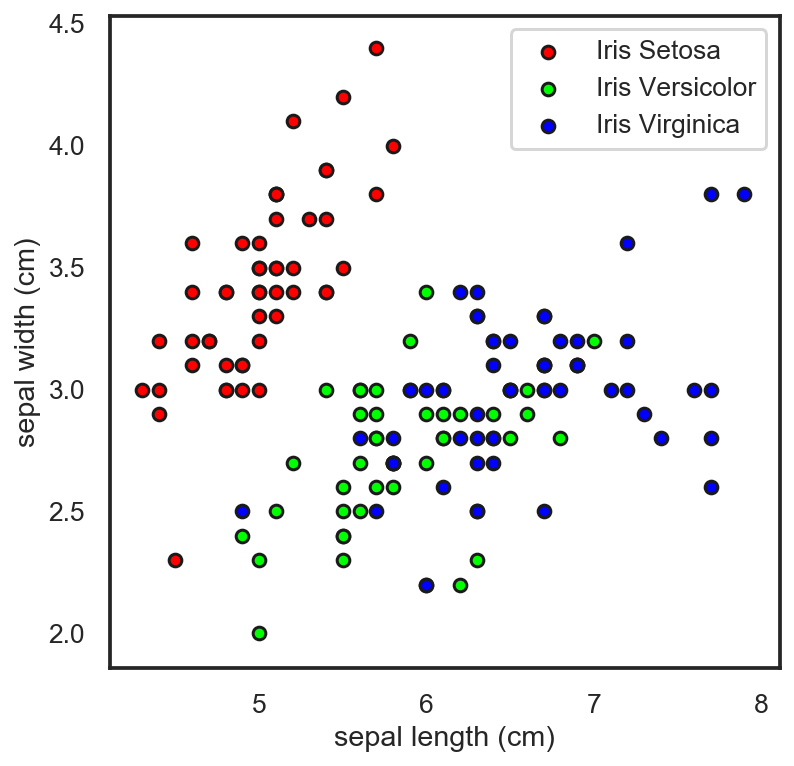

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
iris = datasets.load_iris()
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000',  '#00FF00', '#0000FF'])

K = 3
x = X[-1]

fig, ax = plt.subplots(figsize=(6,6))
for i, iris_class in enumerate(['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']):
    idx = y==i
    ax.scatter(X[idx,0], X[idx,1], 
               c=cmap_bold.colors[i], edgecolor='k', 
               s=40, label=iris_class);
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')
ax.legend();

### Decision boundaries (k = 1 & 13) 

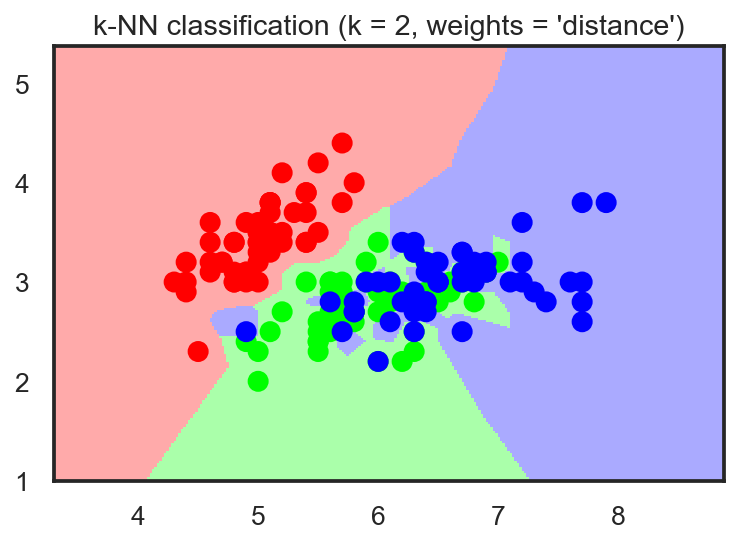

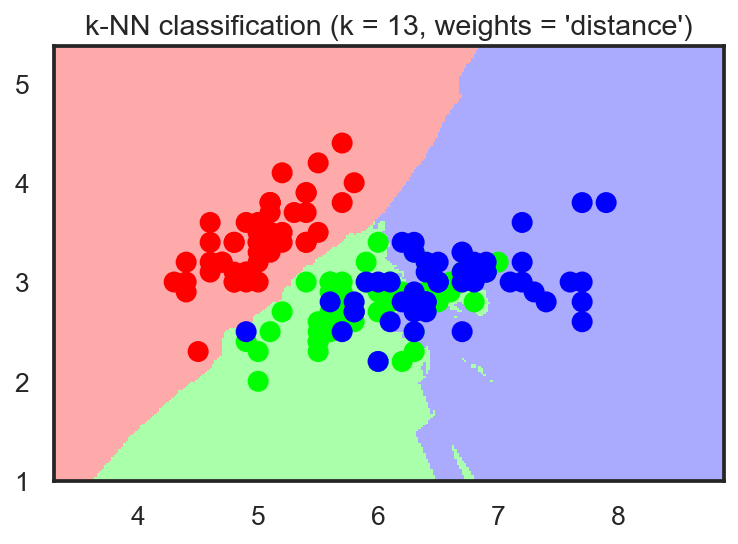

In [36]:
for n_neighbors  in [2, 13]:
    # number of neighbors
    weights = 'distance'
    
    # step size in mesh
    h = 0.02
    
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf_knn.fit(X, y)
    # decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = clf_knn.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("k-NN classification (k = %i, weights = '%s')"
             % (n_neighbors, weights))
    plt.show()

### Decision boundaries (weight = uniform & distance) 

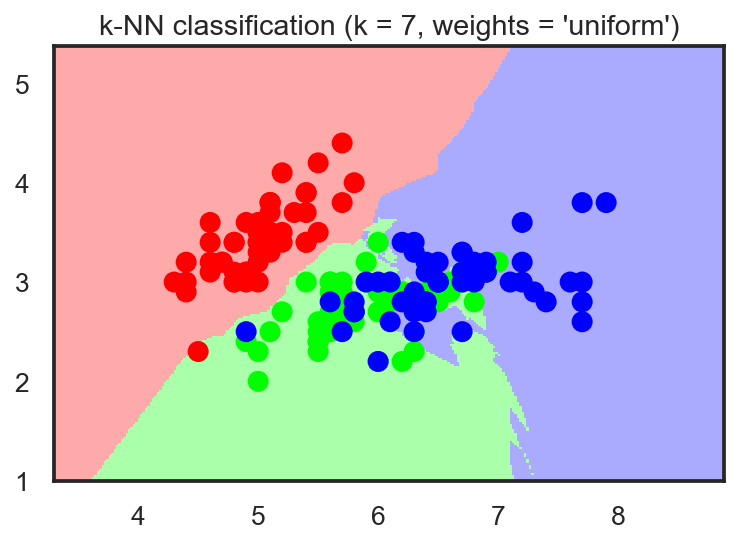

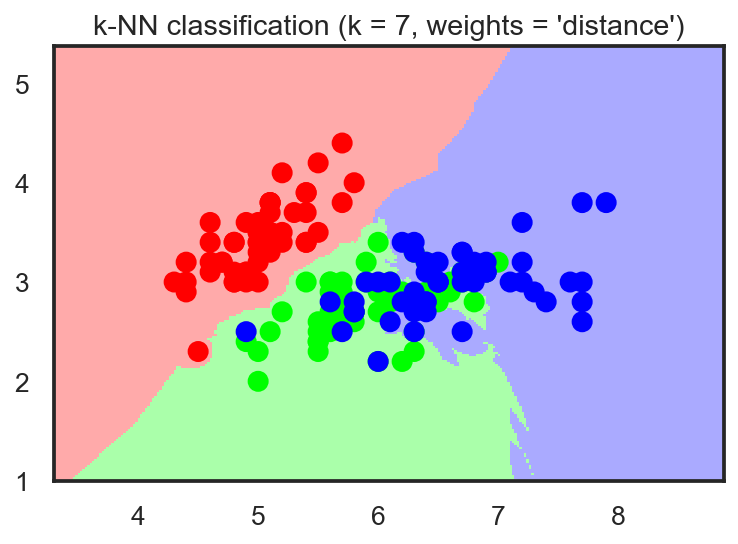

In [22]:
for weights in ['uniform', 'distance']:
    # number of neighbors
    n_neighbors = 7
    
    # step size in mesh
    h = 0.02
    
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf_knn.fit(X, y)
    # decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = clf_knn.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("k-NN classification (k = %i, weights = '%s')"
             % (n_neighbors, weights))
    plt.show()
    

## References and Resources
-  __[Sklearn k-NN classifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)__
-  __[A Course in Machine Learning by Hal Daumé III, Chapter 3: Geometry and Nearest Neighbors](http://ciml.info)__
-  The example used in 2 was an assignment for ARTI 8950 (a class I offered at the University of Georgia in Spring 2020) taught by Dr Sheng Li. All Solutions are mine.
